### The Machine Learning Algorithms

[1. Naive Bayes](#1)

[2. Decision Tree Classifier](#2)

[3. Random Forest](#3)

In [1]:
#importing the libaries needed for model traning and testing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import math 
import pydotplus
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing, linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')

/home/nam/.local/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "


### Enconding categorical variables (Date, WindDir3pm, etc.)

In [2]:
AusWeather = pd.read_csv('data/cleaned_data.csv')
AusWeather = AusWeather.drop(columns=["Unnamed: 0"])

# Date
AusWeather['Date'] = pd.to_datetime(AusWeather['Date'])
# Add 3 more columns: Day, Month and Year
AusWeather.insert(1, 'Year', AusWeather['Date'].dt.year)
AusWeather.insert(1, 'Month', AusWeather['Date'].dt.month)
AusWeather.insert(1, 'Day', AusWeather['Date'].dt.day)
AusWeather.drop(columns=['Date'], axis=1, inplace=True)

# The remaining categorical columns
rain_tomorrow = AusWeather.iloc[:,-1]
risk_mm = AusWeather.iloc[:,-2]
re_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday']
AusWeather = pd.get_dummies(AusWeather, columns=re_columns)
AusWeather.drop(columns=['RISK_MM', 'RainTomorrow'], axis=1, inplace=True)
AusWeather['RISK_MM'] = risk_mm
AusWeather['RainTomorrow'] = rain_tomorrow
AusWeather.columns

Index(['Day', 'Month', 'Year', 'MinTemp', 'MaxTemp', 'Rainfall',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       ...
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'RainToday_No', 'RainToday_Yes',
       'RISK_MM', 'RainTomorrow'],
      dtype='object', length=116)

## Top 5 Features

In [3]:
data = AusWeather.copy()
X = data.iloc[:, :-2]
y = data.iloc[:, -1]
feature_names = X.columns
mutual_info = mutual_info_classif(X, y, discrete_features=True)
mutual_info_dict = dict(zip(feature_names, mutual_info))
print("The Mutual Information:")
for key, value in mutual_info_dict.items():
    print("\t'{0}': {1:.4f}".format(key, value))
mutual_info = mutual_info_classif(X, y, discrete_features=True)

The Mutual Information:
	'Day': 0.0003
	'Month': 0.0016
	'Year': 0.0006
	'MinTemp': 0.0096
	'MaxTemp': 0.0163
	'Rainfall': 0.0641
	'WindGustSpeed': 0.0637
	'WindSpeed9am': 0.0097
	'WindSpeed3pm': 0.0160
	'Humidity9am': 0.0466
	'Humidity3pm': 0.1285
	'Pressure9am': 0.0822
	'Pressure3pm': 0.0781
	'Temp9am': 0.0074
	'Temp3pm': 0.0330
	'Location_Adelaide': 0.0000
	'Location_Albany': 0.0003
	'Location_Albury': 0.0000
	'Location_Alice Springs': 0.0016
	'Location_Badgerys Creek': 0.0000
	'Location_Ballarat': 0.0001
	'Location_Bendigo': 0.0001
	'Location_Brisbane': 0.0000
	'Location_Cairns': 0.0005
	'Location_Canberra': 0.0001
	'Location_Cobar': 0.0006
	'Location_Coffs Harbour': 0.0003
	'Location_Dartmoor': 0.0004
	'Location_Darwin': 0.0001
	'Location_Gold Coast': 0.0001
	'Location_Hobart': 0.0000
	'Location_Katherine': 0.0001
	'Location_Launceston': 0.0000
	'Location_Melbourne': 0.0001
	'Location_Melbourne Airport': 0.0000
	'Location_Mildura': 0.0010
	'Location_Moree': 0.0005
	'Location_Mount

In [4]:
sorted_mutual_info_dict = {k: v for k, v in sorted(mutual_info_dict.items(), 
                            key=lambda item: item[1], reverse=True)}
key_from_sorted_dict = list(sorted_mutual_info_dict.keys())

# Top 5
print("\nTop 5 features:")
top_5 = []
for i in range(5):
    top_5.append(key_from_sorted_dict[i])
    print("\t-", key_from_sorted_dict[i])


Top 5 features:
	- Humidity3pm
	- Pressure9am
	- Pressure3pm
	- Rainfall
	- WindGustSpeed


## 1. Naive Bayes<a id="1"></a>

In [5]:
# For all categorical variables
data = AusWeather.copy()
X = data[top_5]
y = data.iloc[:, -1]
y.replace({'No': 0, 'Yes': 1},inplace = True)
X

,Humidity3pm,Pressure9am,Pressure3pm,Rainfall,WindGustSpeed
0,22.0,1007.7,1007.1,0.6,44.0
1,25.0,1010.6,1007.8,0.0,44.0
2,30.0,1007.6,1008.7,0.0,46.0
3,16.0,1017.6,1012.8,0.0,24.0
4,33.0,1010.8,1006.0,1.0,41.0
...,...,...,...,...,...
142188,27.0,1024.7,1021.2,0.0,31.0
142189,24.0,1024.6,1020.3,0.0,31.0
142190,21.0,1023.5,1019.1,0.0,22.0
142191,24.0,1021.0,1016.8,0.0,37.0


In [6]:
# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Create a Gaussian Classifier  model
gnb = GaussianNB()

# Fit the model to training set
model = gnb.fit(X_train, y_train)

# Predictions
y_predict = gnb.predict(X_test)

In [7]:
print('The accuracy score of model: {:.4f}'.format(metrics.accuracy_score(y_test, y_predict)))
print('The accuracy score of training set: {:.4f}'.format(gnb.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(gnb.score(X_test, y_test)))

The accuracy score of model: 0.8148
The accuracy score of training set: 0.8148
The accuracy score of testing set: 0.8148


In [8]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     22067
           1       0.64      0.39      0.48      6372

    accuracy                           0.81     28439
   macro avg       0.74      0.66      0.69     28439
weighted avg       0.80      0.81      0.80     28439



### Conclusion

In [90]:
"""
The accuracy score are high, so it performs well to decide
whether it will rain tomorrow or not. In other words, it can 
predict on tomorrow weather accurately
"""
print("Go next")

Go next


## 2. Decision Tree Classifier<a id="2"></a>

In [9]:
data = AusWeather.copy()
X = data[top_5]
y = data.iloc[:, -1]

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

,Humidity3pm,Pressure9am,Pressure3pm,Rainfall,WindGustSpeed
0,0.22,0.773110,0.789666,0.021739,0.513514
1,0.25,0.794199,0.794708,0.000000,0.513514
2,0.30,0.772383,0.801191,0.000000,0.540541
3,0.16,0.845104,0.830724,0.000000,0.243243
4,0.33,0.795654,0.781742,0.036232,0.472973
...,...,...,...,...,...
142188,0.27,0.896736,0.891231,0.000000,0.337838
142189,0.24,0.896009,0.884748,0.000000,0.337838
142190,0.21,0.888010,0.876105,0.000000,0.216216
142191,0.24,0.869829,0.859537,0.000000,0.418919


In [9]:
# Create a decision tree model with max_depth=3
DTree = DecisionTreeClassifier(max_depth=3, random_state=1, criterion="entropy")

# Fit the model to training set
model = DTree.fit(X_train, y_train)

# Predictions
y_predict = DTree.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(DTree.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(DTree.score(X_test, y_test)))

The accuracy score of training set: 0.8390
The accuracy score of testing set: 0.8411


### Find the best max_depth in range bewteen 1 and 30

In [41]:
depth_range = range(1,30)
# Apply 10-fold cross-valation for every single value in depth_range and
# return training scores and test scores
train_scores, test_scores = validation_curve(DTree, X_train, y_train, 
                                              param_name="max_depth", 
                                              param_range=depth_range,
                                              cv=10, scoring="accuracy")

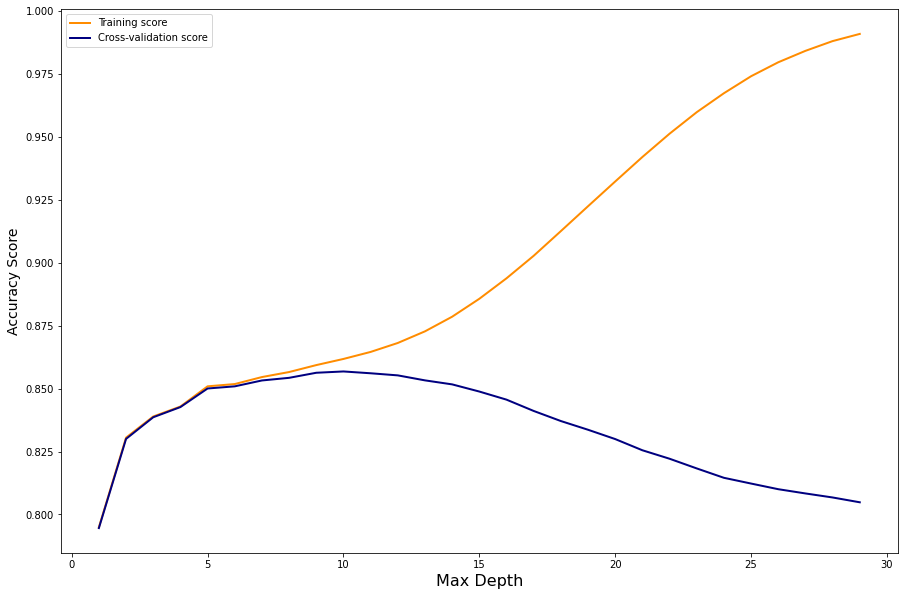

In [42]:
fig, ax = plt.subplots(figsize=(15,10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

ax.plot(depth_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
ax.plot(depth_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
ax.set_xlabel("Max Depth", fontsize=16)
ax.set_ylabel("Accuracy Score", fontsize=14)
ax.legend(loc="best")
fig.savefig("img/ScoreInDecisionTree.pdf")

In [49]:
"""
When the value of max_depth is smaller than 5 
as both training score and validation score are low, the model is underfitting. 
When these max_depth values are higher than 6, the model starts becoming overfitting 
because two lines have their own intention in different directions where
the validation score is poor and the testing score is good.
"""
print("Go next")

Go next


### max_depth = 5

In [10]:
# Create a decision tree model with max_depth=5
DTree = DecisionTreeClassifier(max_depth=5, random_state=1, criterion="entropy")

# Fit the model to training set
model = DTree.fit(X_train, y_train)

# Predictions
y_predict = DTree.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(DTree.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(DTree.score(X_test, y_test)))

The accuracy score of training set: 0.8513
The accuracy score of testing set: 0.8535


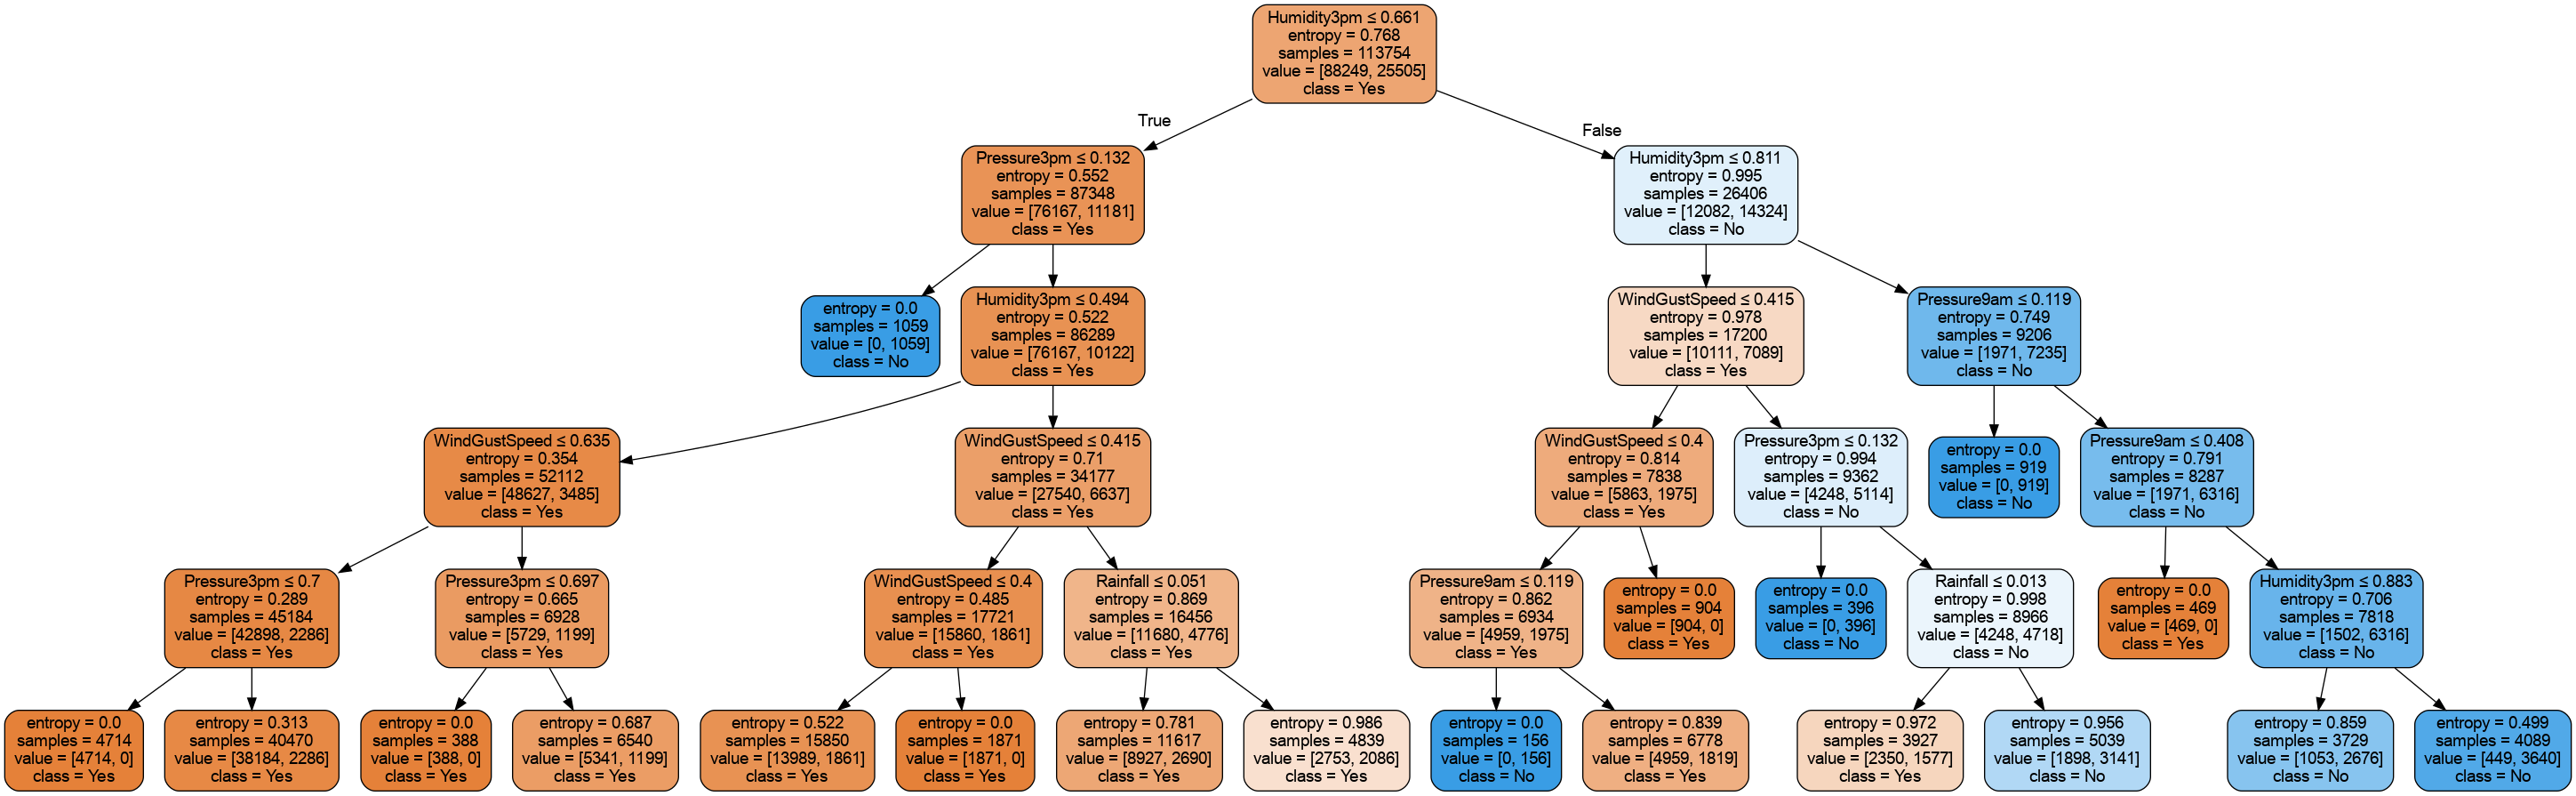

In [11]:
# Visualize tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
               filled=True, rounded=True,
               special_characters=True,
                feature_names=X.columns, 
                class_names=["Yes", "No"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("img/DeCisionTree.pdf")
Image(graph.create_png())
# Go to "img" folder in the current directory
# to see the Tree graph more clearly 

In [12]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          No       0.86      0.96      0.91     22067
         Yes       0.79      0.48      0.59      6372

    accuracy                           0.85     28439
   macro avg       0.82      0.72      0.75     28439
weighted avg       0.85      0.85      0.84     28439



### Try with dimensionality reduction PCA

In [70]:
data = AusWeather.copy()
X = data[top_5]
y = data.iloc[:, -1]

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Reduce big dimensions to 3 dimensions
pca = PCA(3)
X = pca.fit_transform(X)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

array([[-0.01843284, -0.2899463 ,  0.07533189],
       [-0.03626759, -0.26768005,  0.06788451],
       [-0.02235763, -0.2208447 ,  0.08980715],
       ...,
       [-0.17098372, -0.29687385, -0.2109904 ],
       [-0.13885529, -0.27161919, -0.01910038],
       [-0.13286843, -0.27078424, -0.13639213]])

In [71]:
# Create a decision tree model with max_depth=5
DTree = DecisionTreeClassifier(max_depth=5, random_state=1, criterion="entropy")

# Fit the model to training set
model = DTree.fit(X_train, y_train)

# Predictions
y_predict = DTree.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(DTree.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(DTree.score(X_test, y_test)))

The accuracy score of training set: 0.8430
The accuracy score of testing set: 0.8429


In [72]:
"""
The dataset exprencing the PCA process leads to a faster process
of training model. It makes the model have the similar perfomance without
PCA
"""
print("Go next")

Go next


### Conclusion

In [73]:
"""
The Decision Tree Classifier model returns the high accuracy scores
in both test and training sets. Therefore, this model can predict accurately
the state of Australian tomorrow weather. 
"""
print("Go next")

Go next


## 3. Random Forest<a id="3"></a>

In [13]:
data = AusWeather.copy()
X = data[top_5]
y = data.iloc[:, -1]

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# # Reduce big dimensions to 3 dimensions
# pca = PCA(3)
# X = pca.fit_transform(X)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

,Humidity3pm,Pressure9am,Pressure3pm,Rainfall,WindGustSpeed
0,0.22,0.773110,0.789666,0.021739,0.513514
1,0.25,0.794199,0.794708,0.000000,0.513514
2,0.30,0.772383,0.801191,0.000000,0.540541
3,0.16,0.845104,0.830724,0.000000,0.243243
4,0.33,0.795654,0.781742,0.036232,0.472973
...,...,...,...,...,...
142188,0.27,0.896736,0.891231,0.000000,0.337838
142189,0.24,0.896009,0.884748,0.000000,0.337838
142190,0.21,0.888010,0.876105,0.000000,0.216216
142191,0.24,0.869829,0.859537,0.000000,0.418919


### n_estimators = 100

In [75]:
# Create a random forest with 100 desicison trees
RForest = RandomForestClassifier(n_estimators=100)

# Fit the model to training set
model = RForest.fit(X_train, y_train)

# Predictions
y_predict = RForest.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(RForest.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(RForest.score(X_test, y_test)))

The accuracy score of training set: 0.9998
The accuracy score of testing set: 0.8596


In [77]:
"""
The train-set accuracy score is approximately 1, which makes a big disparity
in score from the testing accuracy score. Since train-set score is high and
oppositely test-set is low, the model become overfitting when dataset is sampled
into 100 random trees.
"""
print("Go next")

Go next


### Find the best n_estimators in range bewteen 1 and 50

In [78]:
### Find the best tree_range in range bewteen 1 and 30
tree_range = range(1,51,2)
# Apply 10-fold cross-valation for every single value in tree_range and
# return training scores and test scores
train_scores, test_scores = validation_curve(RForest, X_train, y_train, 
                                              param_name="n_estimators", 
                                              param_range=tree_range,
                                              cv=10, scoring="accuracy")

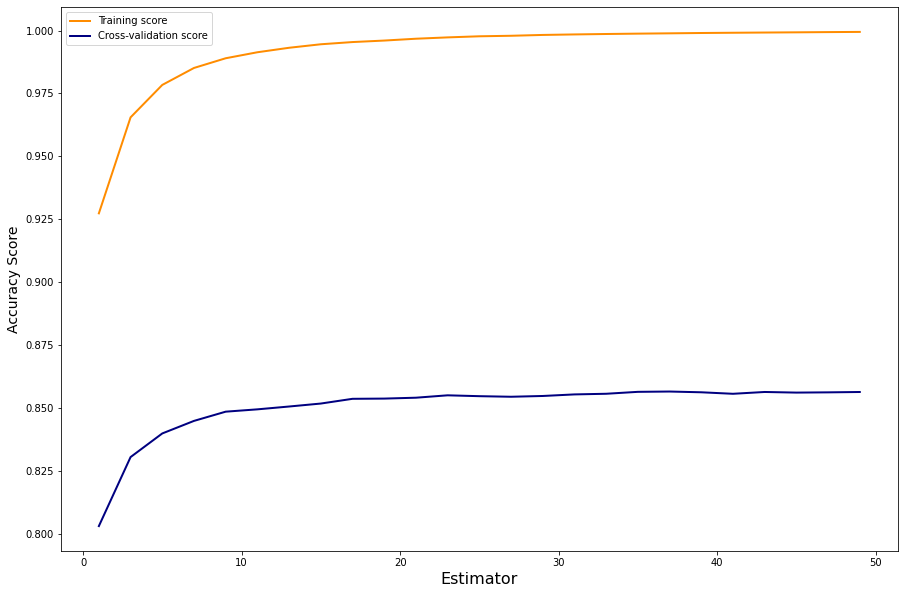

In [79]:
fig, ax = plt.subplots(figsize=(15,10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

ax.plot(tree_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
ax.plot(tree_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
ax.set_xlabel("Estimator", fontsize=16)
ax.set_ylabel("Accuracy Score", fontsize=14)
ax.legend(loc="best")
fig.savefig("img/RandomForest.pdf")

In [80]:
"""
The above graph shows no intersection bewteen two lines of 
train-set score and test-set score, which means two lines seem to
experience parallel to each other over the range from 1 to possibly infinity
Therefore, to avoid less overfiting as possible, the forest consists of 
3 random decision trees.
"""
print("Go next")

Go next


### n_estimators = 3

In [14]:
# Create a random forest with multiple 3 trees
RForest = RandomForestClassifier(n_estimators=3)

# Fit the model to training set
model = RForest.fit(X_train, y_train)

# Predictions
y_predict = RForest.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(RForest.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(RForest.score(X_test, y_test)))

The accuracy score of training set: 0.9646
The accuracy score of testing set: 0.8306


In [15]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          No       0.88      0.91      0.89     22067
         Yes       0.64      0.57      0.60      6372

    accuracy                           0.83     28439
   macro avg       0.76      0.74      0.75     28439
weighted avg       0.82      0.83      0.83     28439



In [82]:
"""
The Random Forest model on this dataset produces a potential state
of overfitting and returns less accurate prediction. Therefore, using 
this model should be considered carefully. However, to return the optimal
performance, the Random Forest should be elemiated out of list of good models
for this dataset.
"""
print("End")

End
